In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import HTML, IFrame, Image, SVG, Latex
import re
import ROOT
from ROOT import RooFit, RooStats
%matplotlib inline
#%matplotlib nbagg
#%matplotlib notebook
from ipywidgets import interact, interactive, fixed

Welcome to JupyROOT 6.18/00


In [5]:
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.DataHandling)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True)

In [2]:
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [3]:
#from notebook.services.config import ConfigManager
#cm = ConfigManager()
#cm.update('livereveal', {
#          'theme': 'sans',
#          'transition': 'zoom',
#})

In [4]:
def iter_collection(rooAbsCollection):
    iterator = rooAbsCollection.createIterator()
    object = iterator.Next()
    while object:
        yield object
        object = iterator.Next()

# Lecture 3

<p style="text-align: center;"><i class="icon-user icon-2x"><a href="mailto:ruggero.turra@mi.infn.it">ruggero.turra@mi.infn.it</a></i></p>
<br/>

## Content of the lecture

   * Systematics
   * Shape analysis
   * Test statistic for discovery and exclusions

Restart from the on/off problem.

We observe the number of events in the signal region $n_{SR}$ and in the control region $n_{CR}$. $\alpha$ is the ratio of the expected background in the CR with respect to the SR. We can write the likelihood as:

$$L(s, b|n_{SR}, n_{CR}) = \text{Pois}(n_{SR}|s + b) \text{Pois}(n_{CR}|\alpha b)$$

The test statistics is based on the profiled likelihood ratio:

$$-2\log\lambda = -2\log\frac{\sup_{b \in [0, \infty], s\in\{0\}}{L(s, b)}}{\sup_{b\in [0, \infty], s\in [0, \infty]}{L(s, b)}} = -2\log\frac{L(0, \hat{\hat{b}}(s=0))}{L(\hat{s}, \hat{b})}$$

## Systematics

How we can incorporate systematics inside our model? Suppose we know the parameter $\alpha$ with a relative uncertainty $\sigma_\alpha$. We can imagine that there is another measurement (auxiliary measurement), that measured $\alpha$ (the parameter of the model of the auxiliary measurement) and observed $a$. We can write the likelihood of the auxiliary measurement as $L(a|\alpha) = N(a|\alpha, \delta_\alpha)$, if assume that $a$ is normally distributed aroud the true value $\alpha$ and $\delta\alpha$ is the absolute error on $\alpha$ ($\delta\alpha=\sigma_\alpha a$)





We can join the auxiliary measurement with our on/off model:

$$L(s, b, a|N_{SR}, N_{CR}, \alpha) = L(s, b|N_{SR}, N_{CR}) L(a|\alpha)$$

or more explicitely:

$$\text{Pois}(N_{SR}|s + b) \text{Pois}(N_{CR}|\alpha b) \times N(a|\alpha, \delta_\alpha)$$

Usually this is written as:

$$\text{Pois}(N_{SR}|s + b) \text{Pois}(N_{CR}|a (1 + \sigma_\alpha\theta_\alpha) b) \times N(0|\theta_\alpha, 1)$$

The first term is called the "physical" pdf, while the second is called the "constraints".


In [5]:
#ws = ws_onoff_withsys = ws_onoff.Clone("ws_onoff_withsys")
f = ROOT.TFile.Open("onoff.root")
ws_onoff = f.Get("ws_onoff")

# create the term kalpha = (1 + sigma * theta) with a relative error of 20%
ws_onoff.factory('expr:kalpha("1 + @0 * @1", {sigma_alpha[0.2], theta_alpha[0, -5, 5]})')
ws_onoff.factory('prod:alpha_x_kappa(alpha, kalpha)')
# create new pdf model replacing alpha -> alpha_x_kalpha
ws_onoff.factory('EDIT:model_with_sys(model, alpha=alpha_x_kappa)')
 
# create new workspace
ws_onoff_sys = ROOT.RooWorkspace('ws_onoff_sys')
getattr(ws_onoff_sys, 'import')(ws_onoff.pdf('model_with_sys'))
# create the constraint
ws_onoff_sys.factory("Gaussian:constraint_alpha(global_alpha[0, -5, 5], theta_alpha, 1)")
ws_onoff_sys.var("global_alpha").setConstant(True)
# final pdf
model = ws_onoff_sys.factory("PROD:model_constrained(model_with_sys, constraint_alpha)")

In [6]:
ws_onoff_sys.Print()


RooWorkspace(ws_onoff_sys) ws_onoff_sys contents

variables
---------
(alpha,b,global_alpha,n_cr,n_sr,s,sigma_alpha,theta_alpha)

p.d.f.s
-------
RooPoisson::N_CR_model_with_sys[ x=n_cr mean=alpha_x_b_model_with_sys ] = 0
RooPoisson::N_SR[ x=n_sr mean=s_plus_b ] = 0
RooGaussian::constraint_alpha[ x=global_alpha mean=theta_alpha sigma=1 ] = 1
RooProdPdf::model_constrained[ model_with_sys * constraint_alpha ] = 0
RooProdPdf::model_with_sys[ N_SR * N_CR_model_with_sys ] = 0

functions
--------
RooProduct::alpha_x_b_model_with_sys[ alpha_x_kappa * b ] = 500
RooProduct::alpha_x_kappa[ alpha * kalpha ] = 10
RooFormulaVar::kalpha[ actualVars=(sigma_alpha,theta_alpha) formula="1+@0*@1" ] = 1
RooAddition::s_plus_b[ s + b ] = 50



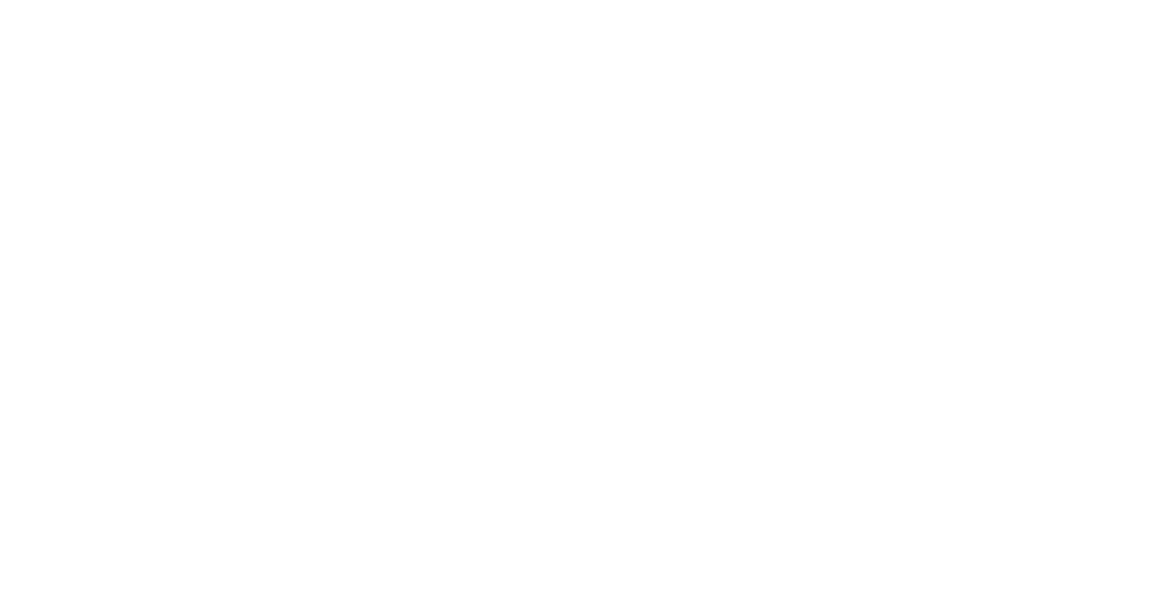

In [7]:
model.graphVizTree("on_off_with_sys_graph.dot")
!dot -Tsvg on_off_with_sys_graph.dot > on_off_with_sys_graph.svg; rm on_off_with_sys_graph.dot
s = SVG("on_off_with_sys_graph.svg")
s.data = re.sub(r'width="[0-9]+pt"', r'width="90%"', s.data)
s.data = re.sub(r'height="[0-9]+pt"', r'height=""', s.data); s

In [8]:
sbModel = ROOT.RooStats.ModelConfig('sbModel_sys', ws_onoff_sys)
sbModel.SetPdf('model_constrained')
sbModel.SetParametersOfInterest('s')
sbModel.SetObservables('n_sr,n_cr')
sbModel.SetNuisanceParameters('theta_alpha')
ws_onoff_sys.var('s').setVal(30)
sbModel.SetSnapshot(ROOT.RooArgSet(ws_onoff_sys.var('s')))
getattr(ws_onoff_sys, 'import')(sbModel)

bModel = sbModel.Clone("bModel_sys")
ws_onoff_sys.var('s').setVal(0)
bModel.SetSnapshot(bModel.GetParametersOfInterest())
getattr(ws_onoff_sys, 'import')(bModel)

False

In [9]:
sbModel.LoadSnapshot()
ws_onoff_sys.var('s').Print()
data = model.generate(bModel.GetObservables(), 1)
data.SetName('obsData')
print("observed  N_SR = %.f, N_CR = %.f" % tuple([x.getVal() for x in iter_collection(data.get(0))]))
model.fitTo(data)
print("best fit")
print("SR {:>8.1f} {:>8.1f}".format(ws_onoff_sys.var('s').getVal(), ws_onoff_sys.var('b').getVal()))
print("CR          {:>8.1f}".format(ws_onoff_sys.function('alpha_x_b_model_with_sys').getVal()))
getattr(ws_onoff_sys, 'import')(data)
ws_onoff_sys.writeToFile('onoff_sys.root')

observed  N_SR = 79, N_CR = 528
best fit
SR     26.2     52.8
CR             528.0


False

RooRealVar::s = 30  L(0 - 100) 


In [10]:
# create profiled log-likelihood as a function of s
ws_onoff_sys.var('theta_alpha').setConstant(False)
prof = model.createNLL(data).createProfile(ROOT.RooArgSet(ws_onoff_sys.var('s')))
# multiply by 2
minus2LL = ROOT.RooFormulaVar("minus2LL", "2 * @0", ROOT.RooArgList(prof))
frame = ws_onoff.var('s').frame(0, 60)
minus2LL.plotOn(frame)

ws_onoff_sys.var('theta_alpha').setConstant(True)
minus2LL.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))
frame.SetYTitle("-2 log#Lambda(s)")

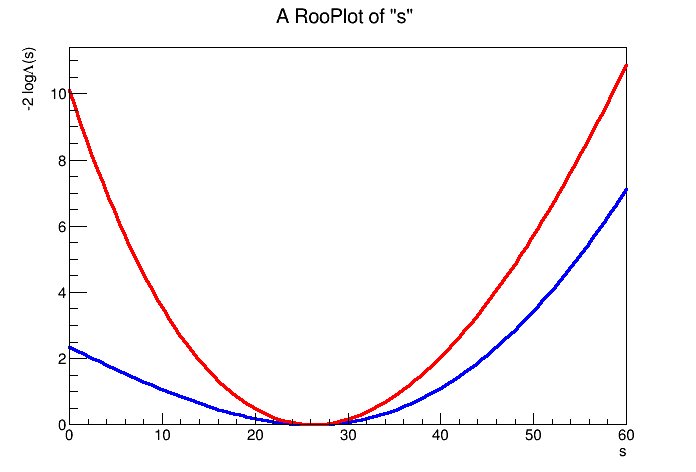

In [11]:
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()

## Excercize
Explain why the profile likelihood curve is larger when adding systematics

### Compute the significance with systematics

In [6]:
f = ROOT.TFile.Open("onoff_sys.root")
ws_onoff_sys = f.Get("ws_onoff_sys")
ws_onoff_sys.var('theta_alpha').setConstant(False)
data = ws_onoff_sys.data('obsData')
sbModel = ws_onoff_sys.obj('sbModel_sys')
bModel = ws_onoff_sys.obj('bModel_sys')
hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
hypoCalc.SetOneSidedDiscovery(True)
htr = hypoCalc.GetHypoTest()
print("pvalue =", htr.NullPValue(), " significance =", htr.Significance())

pvalue = 0.06329824777957065  significance = 1.527661935394446
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 b            5.27871e+01  1.07196e+01    0.00000e+00  1.00000e+02
     2 s            2.62162e+01  1.00000e+01    0.00000e+00  1.00000e+02
     3 theta_alpha   1.25567e-03  9.93514e-01   -5.00000e+00  5.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        1500           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=7.15836 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=1.51144e-06   

### (Big) exercize

Suppose you are looking for a signal in a SR. There are two main background on the signal region, due to two different physical processes, B1 and B2. You also have two CRs. The simulation predicts the following countings for an equivalent luminosity of 1/fb.


|  ``   |  SR | CR1  | CR2  |
|-----|-----|-----|-----|
|  B1 |  10 | 100 | 20  |
|  B2 |  20 |  30 | 500 |

You don't trust the cross section of the background, so you assume a degree of freedom for every process. For example:

$$n_{B1}^{SR,exp} = L\times k_{B1}\times n_{B1}^{SR,mc}$$
$$n_{B1}^{CR1,exp} = L\times k_{B1}\times n_{B1}^{CR1,mc}$$

where $L$ is the observed luminosity. Note that we are using the correlation between SR/CR1/CR2 of the simulation. Assume  L=10/fb +/- 5%. 

Suppose you analysis is blinded (you haven't look to the signal region) and you observe: CR1=1509, CR2=5017 events.

How many events do you have to observe in the signal region to claim a discovery at 3 sigma (what is the acceptance region)? What is the impact of the systematics? Bonus: take into account the MC statistical uncertainty of 3% for every prediction.

For this kind of analyses usually [HistFactory](https://twiki.cern.ch/twiki/bin/view/RooStats/HistFactory) is used to produce the workspace.

Costraints can be gaussian:
    
   $$m\to m(1 + \sigma\theta) \qquad L \to L \times G(0, \theta, 1)$$
   
or log-normal, for example for quantity that cannot be negative (e.g. efficiencies):

   $$\varepsilon\to \varepsilon\exp(\sigma\theta)\qquad L \to L \times G(0, \theta, 1)$$
   


### Exercize (big)

Find a better constrain for log-normal variable. Suppose you have a random variable $Y$ that is log-normal distributed. Do a change of variable and write it as $Y = a\exp(b \Theta)$. How is distributed $\Theta$? How can I constrain $\Theta$? Suppose I know the median of $Y$ ($=Y_0$) and the standard deviation $\sigma\times Y_0$. What are the values of $a$ and $b$ if I want to conserve the median and the standard deviation? What is the value of $y$ if $\theta=1$? Is it $Y_0 + \sigma Y_0$? If not, give an approximation in terms of $O(\sigma)$ for small $\sigma$.

## Shape analysis

In more complicate analysis you don't look just to the number of events in specific region but you look to the distribution of the events as a function of a continuos variable (e.g. invariant mass).

$$L(\alpha|\{m_i\}_{i=1}^n) = \text{Pois}[n|N_s(\alpha) + N_b(\alpha)] \prod_{i=1}^n\left(\frac{N_s(\alpha) f_s[m_i|\alpha] + N_b(\alpha) f_b[m_i|\alpha]}{N_s(\alpha)+N_b(\alpha)}\right)\times\prod_j L(a_j|\alpha_j)$$

Where $\alpha$ is a set of nuisance parameters, $\{m_i\}_{i=1}^n$ are the data, $N_s$ and $N_b$ the predicted number of signal and background events, $f_s$ and $f_b$ the pdf describing the continuos observable.

The last term is the product of all the constraints of the nuisance parameters (not all the nuisance parameters need to be constrained by auxiliary measurements). The other term is the extended likelihood of the s+b model.

If the signal is localised the background shape can be fully data-driven. This means that the nuisance parameters for the background shape are completely free.

### Example model

Suppose we observe the invariant mass distribution and we are searching for a narrow resonance in the spectrum. Our signal + background model is (after many careful studies) an exponential plus a gaussian. We also know the expected number of events for the signal under a particular theory. We want to be able to parametrize also similar model, where the number of signal events is multiplied by the "signal strength", $\mu$. So we will write the number of signal events as $\mu \times n_{exp}$ where $n_{exp}$ are the one from the nominal theory. In this way we can also write the background-only model as the special case for $\mu=0$. The number of background events are not well know by the theory, so we can estimate them from data, which means that $n_b$ is a nuisance parameters in the model.

Consider systematic on the luminosity, scale and resolution of the signal (location and width)

In [7]:
ws = ROOT.RooWorkspace("ws_shape")
mH = ws.factory("mH[125, 90, 150]")  # true mass of the resonance
mass = ws.factory("mass[80, 160]")    # observed invariant mass
ws.factory('expr:kpeak("1 + @0 * @1", {sigma_mH[0.01], theta_mH[0, -5, 5]})')
peak = ws.factory('expr:peak("@0 * @1", {mH, kpeak})')   # peak position for signal
ws.factory('expr:kwidth("1 + @0 * @1", {sigma_width[0.05], theta_width[0, -5, 5]})')
width = ws.factory('expr:width("@0 * @1", {nominal_width[5], kwidth})')
signal = ws.factory("RooGaussian:signal(mass, peak, width)")
ws.factory("RooExponential:background(mass, tau[-0.03, -0.5, -0.001])")
ws.factory("nbkg[400, 0, 1000]")
ws.factory('expr:klumi("(1 + exp(@0 * @1))", {sigma_lumi[0.02], theta_lumi[0, -5, 5]})')
ws.factory('expr:efficiency("@0 * (1 + exp(@1 * @2))", {nominal_efficiency[0.6], sigma_efficiency[0.05], theta_efficiency[0, -5, 5]})')
ws.factory('expr:nsignal_theory("7 + @0 * 0.2", {mH})')
ws.factory('prod:nsignal(nsignal_theory, mu[1, -2, 5], efficiency, klumi)')
ws.factory("SUM:phys_pdf(nsignal * signal, nbkg * background)")
ws.factory("RooGaussian:constrain_peak(global_peak[0, -5, 5], theta_mH, 1)")
ws.factory("RooGaussian:constrain_width(global_width[0, -5, 5], theta_width, 1)")
ws.factory("RooGaussian:constrain_lumi(global_lumi[0, -5, 5], theta_lumi, 1)")
ws.factory("RooGaussian:constrain_eff(global_efficiency[0, -5, 5], theta_efficiency, 1)")
ws.factory("PROD:constraints(constrain_peak, constrain_lumi, constrain_width, constrain_eff)")
model = ws.factory("PROD:model(phys_pdf, constraints)")

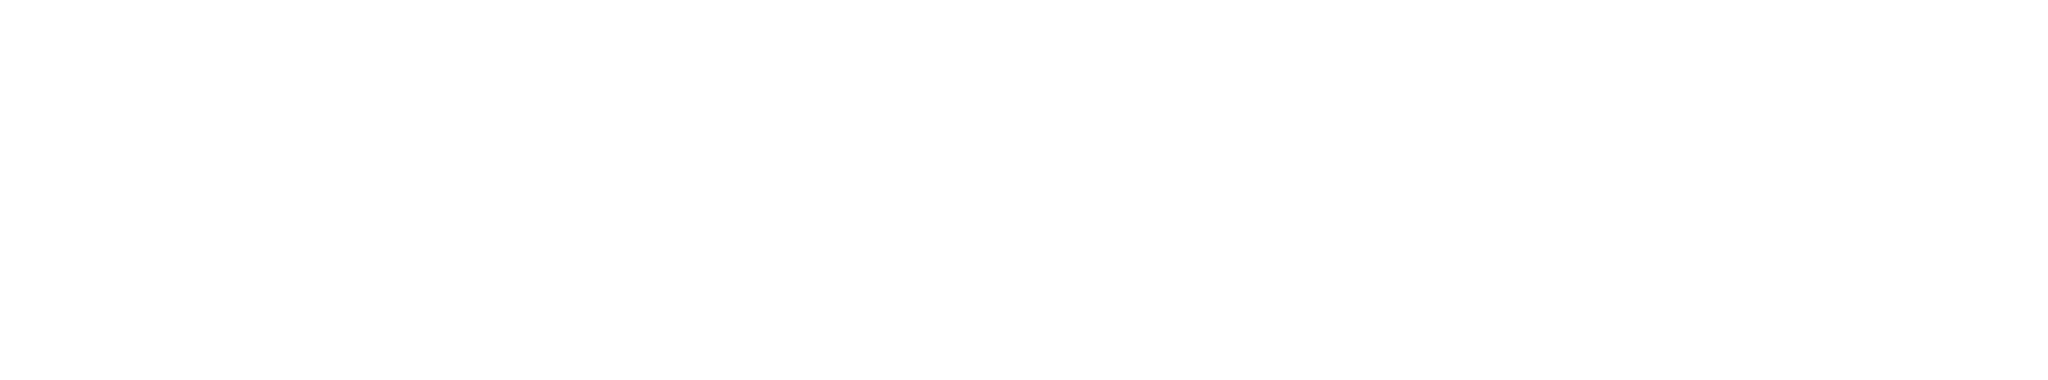

In [8]:
model.graphVizTree("shape_graph.dot")
!dot -Tsvg shape_graph.dot > shape_graph.svg; rm shape_graph.dot
s = SVG("shape_graph.svg")
s.data = re.sub(r'width="[0-9]+pt"', r'width="90%"', s.data)
s.data = re.sub(r'height="[0-9]+pt"', r'height=""', s.data)
s

In [9]:
RooStats.SetAllConstant(ws.allVars().selectByName('global*'))

data = model.generate(ROOT.RooArgSet(mass))
data.SetName('obsData')
getattr(ws, 'import')(data)

False

In [10]:
ROOT.RooMsgService.instance().setGlobalKillBelow(5)
fit_result = model.fitTo(data, ROOT.RooFit.Save(), RooFit.PrintLevel(0))

 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mH           1.25000e+02  6.00000e+00    9.00000e+01  1.50000e+02
     2 mu           1.00000e+00  7.00000e-01   -2.00000e+00  5.00000e+00
     3 nbkg         4.00000e+02  1.00000e+02    0.00000e+00  1.00000e+03
     4 tau         -3.00000e-02  1.45000e-02   -5.00000e-01 -1.00000e-03
     5 theta_efficiency   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     6 theta_lumi   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     7 theta_mH     0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     8 theta_width   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        4000           1
 ****

In [11]:
fit_result.Print()


  RooFitResult: minimized FCN value: -450.874, estimated distance to minimum: 0.000114913
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    mH    1.2631e+02 +/-  1.88e+00
                    mu    7.2047e-01 +/-  1.67e-01
                  nbkg    4.2126e+02 +/-  2.30e+01
                   tau   -2.9783e-02 +/-  2.72e-03
      theta_efficiency   -7.2290e-03 +/-  9.93e-01
            theta_lumi   -2.8560e-03 +/-  9.93e-01
              theta_mH    2.0973e-03 +/-  9.94e-01
           theta_width    1.1486e-01 +/-  9.82e-01



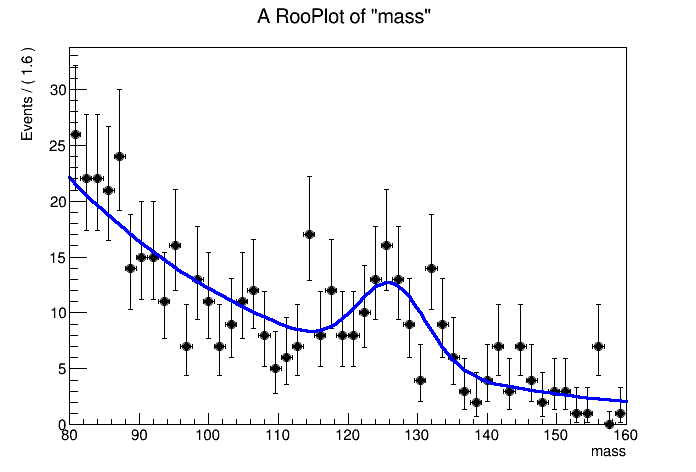

In [13]:
frame = mass.frame(50)
data.plotOn(frame)
model.plotOn(frame)
frame.Draw()
ROOT.gPad.Draw()

In [14]:
sbModel = RooStats.ModelConfig('sbModel', ws)
sbModel.SetPdf('model')
nps = ws.allVars().selectByName('theta*')
nps.add(ws.var('tau'))
nps.add(ws.var('nbkg'))
sbModel.SetNuisanceParameters(nps)
sbModel.SetObservables('mass')
sbModel.SetParametersOfInterest('mu')
sbModel.SetGlobalObservables(ws.allVars().selectByName('global*'))
sbModel.SetSnapshot(ROOT.RooArgSet(ws.var('mu')))

bModel = sbModel.Clone('bModel')
ws.var('mu').setVal(0)
bModel.SetSnapshot(ROOT.RooArgSet(ws.var('mu')))

getattr(ws, 'import')(sbModel)
getattr(ws, 'import')(bModel)

ws.writeToFile('ws_shape.root')

False

## Test statistics $t_\mu$ and $\tilde{t}_\mu$

$$ t_\mu = -2\log\lambda (\mu) = -2\log \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})}$$

High value means incompatiblity with data. If we want to test a specific $\mu$ we can compute the p-value $= \int_{t_{\mu, obs}}^\infty f(t_\mu|\mu) dt_\mu$.

Usually we can assume that $\mu\geq 0$, so we need a new test statistic:

$$ \tilde{t}_\mu = -2\log \tilde\lambda(\mu)$$

$$ \tilde\lambda(\mu) = \begin{cases} 
      \hfill \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(0, \hat{\theta}(0))}    \hfill & \hat{\mu} < 0 \\
      \hfill \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})} \hfill & \hat{\mu} \geq 0 \\
  \end{cases}$$

## $q_0$ statistics for discovery of positive signal

For discovery we want to exclude the hypothesis $s=0$ (background-only), assuming $\mu\geq 0$. Defining $q_0 = \tilde{t}_0$:

$$ q_0 = 
\begin{cases} 
-2\log\lambda(0)\qquad &\hat \mu\geq 0 \\
0\qquad &\hat \mu < 0
\end{cases}
$$

If $\hat \mu<0$ it means that we are observing less events than the one predicted by the background-only model. Since we are truncating the definition of test statistics we are not considering downward fluctuation as discrepancies with the model. High value of $\hat\mu$ means high value of $q_0$ and large discrepancy with the background-only model.

 The p-value is computed as usual:

$$ \text{p-value} = p_0 = \int_{q_{0, obs}}^\infty f(q_0|\mu=0)\, dq_0$$

### Exercize
If we assume that the background model is true, how many times we will get $\hat \mu<0$? If $f(t_0|\mu=0)$ is a $\chi^2$ distribution what about $f(q_0|\mu=0)$?

## $q_\mu$ statistic for exclusion
Suppose we want to put an upper limit, so we define as null hypothesis to exclude the hypotesis signal+background with $\mu$ as signal multiplier.

$$
q_\mu=\begin{cases}
-2\log\lambda(\mu)\qquad & \hat\mu \leq \mu\\
0 \qquad & \hat\mu > \mu
\end{cases}
$$

we set $q_\mu=0$ when observing a value of $\mu$ greater than the one we are observing since we don't want it to enter in the rejection region when doing an upper limit; we don't want that upper fluctuation count as bad agreement with data.

 The p-value is computed in the usual way, assuming the null-hypothesis ($\mu$) true:

$$ \text{p-value} = p_\mu = \int_{q_{\mu, obs}}^\infty f(q_\mu|\mu)\, dq_\mu$$


### Questions
What is the relation between $q_\mu$ and $q_0$? Are you looking in the same tail of $\mu$?

Let's try to write the profiled likelihood ratio for the shape model:

$$\frac{\sup L(0, m_H, \theta)}{\sup L(\mu, m_H, \theta)}$$

Is $m_H$ playing a role in the numerator? No! The numerator is not a special case of the numerator! $m_H$ is not a nuisance parameter that can be profiled.

The commont solution is to repeat the test for fixed value of $m_H$: in that case $m_H$ is considered to be a constant.

In [16]:
RooStats.AsymptoticCalculator.SetPrintLevel(-1)
mH_values = np.linspace(mH.getMin(), mH.getMax(), 20)
pvalues, pvalues_exp, zs, qvalues = [], [], [], []
for mH_value in mH_values:
    f = ROOT.TFile('ws_shape.root')
    ws = f.Get('ws_shape')
    mH = ws.var('mH')
    mH.setVal(mH_value)
    mH.setConstant(True)
    data = ws.data('obsData')
    #ws.pdf('model').fitTo(data)   # better to do a fit before
    sbModel = ws.obj('sbModel')
    bModel = ws.obj('bModel')
    hypoCalc = RooStats.AsymptoticCalculator(data, sbModel, bModel)
    hypoCalc.SetOneSidedDiscovery(True)
    htr = hypoCalc.GetHypoTest()
    print("mH = ", mH.getVal(), "pvalue =", htr.NullPValue(), " significance =", htr.Significance())
    pval_exp = RooStats.AsymptoticCalculator.GetExpectedPValues(htr.NullPValue(), htr.AlternatePValue(), 0, False)
    pvalues.append(htr.NullPValue()); zs.append(htr.Significance()); pvalues_exp.append(pval_exp)
    del hypoCalc
    del htr

mH =  90.0 pvalue = 0.5  significance = -0.0
mH =  93.15789473684211 pvalue = 0.5  significance = -0.0
mH =  96.3157894736842 pvalue = 0.5  significance = -0.0
mH =  99.47368421052632 pvalue = 0.5  significance = -0.0
mH =  102.63157894736842 pvalue = 0.5  significance = -0.0
mH =  105.78947368421052 pvalue = 0.5  significance = -0.0
mH =  108.94736842105263 pvalue = 0.5  significance = -0.0
mH =  112.10526315789474 pvalue = 0.5  significance = -0.0
mH =  115.26315789473685 pvalue = 0.1609545422184508  significance = 0.9905423818071366
mH =  118.42105263157895 pvalue = 0.001236936777394594  significance = 3.026518899111132
mH =  121.57894736842105 pvalue = 8.42717149510897e-06  significance = 4.30294404143259
mH =  124.73684210526315 pvalue = 5.170262350169288e-07  significance = 4.885044975759736
mH =  127.89473684210526 pvalue = 5.18732626895524e-07  significance = 4.8843957305672445
mH =  131.05263157894737 pvalue = 8.87401813028884e-06  significance = 4.291487290776653
mH =  134.21

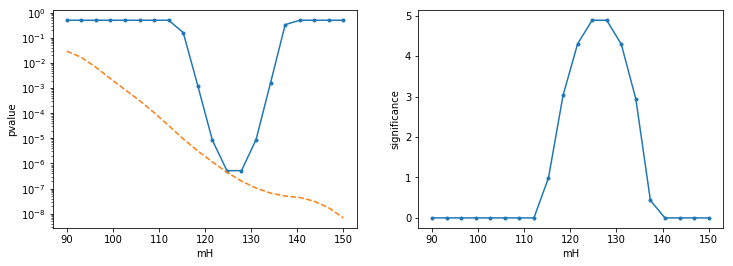

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(mH_values, pvalues, '.-')
axs[0].semilogy(mH_values, pvalues_exp, '--')
axs[1].plot(mH_values, zs, '.-')
axs[0].set_xlabel('mH'); axs[1].set_xlabel('mH')
axs[0].set_ylabel('pvalue'); axs[1].set_ylabel('significance'); plt.show()

### Question
Explain why p-value is never bigger than 0.5 (we have used $q_0$ as test statistic).

### Look elsewhere effect

The maximum significance we have found is 5 around 125. Usually this is called "local significace", since it is computed for a particular $m_H$. The problem is that we have repeated the test many times and we have to consider that we are taking into account the maximum discrepancy. This is also know as "problem of multiple comparisons".

One can solve this problem redefining the test statistic as:

$$q_0^{global} = \max_{m_H} q_0(m_H)$$

But the distribution of $q_0^{global}$ is unknown. The other solution is to introduce a "trial factor" to correct the local-$p_0$ to obtain the global-$p_0$.

In [18]:
IFrame("http://xkcd.com/882/", 900, 500)

## Exclusions

We are also interested to know what is the minimum $\mu$ that we can exclude. This is done as hypothesis inversion. We have to find a $\mu_{95}$ that is exluded at 5%. As before this is done with a simple scan. Let's do it for $m_H=110 GeV$.

In [25]:
f = ROOT.TFile('ws_shape.root')
ws = f.Get("ws_shape")
ws.var('mH').setVal(110)
ws.var('mH').setConstant(True)
ws.var('mu').setRange(0, 1)
ws.writeToFile("ws_shape_110.root")

False

In [26]:
ROOT.gROOT.LoadMacro('StandardHypoTestInvDemo.C')
ROOT.StandardHypoTestInvDemo("ws_shape_110.root", "ws_shape", "sbModel", "bModel", "obsData", 2, 3, True, 30)

0x55e8fc847930	ws_shape_110.root
Running HypoTestInverter on the workspace ws_shape

RooWorkspace(ws_shape) ws_shape contents

variables
---------
(global_efficiency,global_lumi,global_peak,global_width,mH,mass,mu,nbkg,nominal_efficiency,nominal_width,sigma_efficiency,sigma_lumi,sigma_mH,sigma_width,tau,theta_efficiency,theta_lumi,theta_mH,theta_width)

p.d.f.s
-------
RooExponential::background[ x=mass c=tau ] = 0.0280459
RooGaussian::constrain_eff[ x=global_efficiency mean=theta_efficiency sigma=1 ] = 0.999974
RooGaussian::constrain_lumi[ x=global_lumi mean=theta_lumi sigma=1 ] = 0.999996
RooGaussian::constrain_peak[ x=global_peak mean=theta_mH sigma=1 ] = 0.999998
RooGaussian::constrain_width[ x=global_width mean=theta_width sigma=1 ] = 0.993425
RooProdPdf::constraints[ constrain_peak * constrain_lumi * constrain_width * constrain_eff ] = 0.993393
RooProdPdf::model[ phys_pdf * constraints ] = 0.0278606
RooAddPdf::phys_pdf[ nsignal * signal + nbkg * background ] = 0.0280459
RooGaussi

Info in <StandardHypoTestInvDemo>: Using Minuit as minimizer for computing the test statistic
Info in <StandardHypoTestInvDemo>:  Doing a first fit to the observed data 
Info in <StandardHypoTestInvDemo>: HypoTestInverterResult has been written in the file Asym_CLs_grid_ts3_ws_shape_110.root
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Asymptotic_Scan
Warning in <TROOT::Append>: Replacing existing TH1: CLs_observed (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: CLs_observed (Potential memory leak).


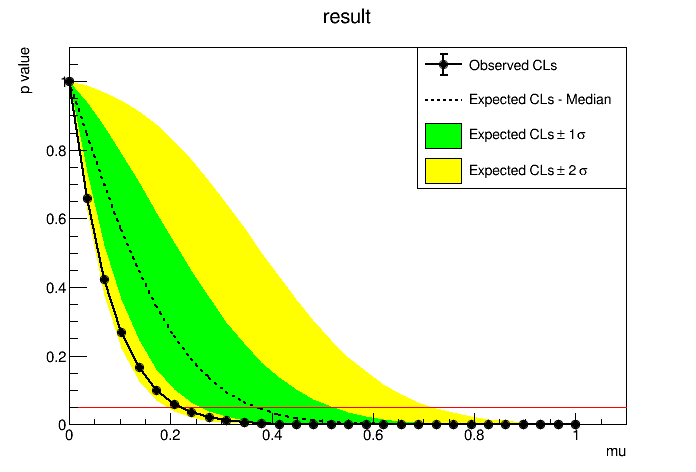

In [27]:
fresult = ROOT.TFile("Asym_CLs_grid_ts3_ws_shape_110.root")
result = fresult.Get("result_mu")
plot = RooStats.HypoTestInverterPlot("result", "result", result)
plot.Draw()
ROOT.gPad.Draw()

## Example of result you can find around

<img src="img/figaux_004a.png" width="80%">

<img src="img/figaux_007a.png" width="90%">

<img src="img/figaux_007b.png" width="90%">

<img src="img/atlas_mH_ws.jpg" width="75%">

## Topic not coverted, but important if you want to do hypothesis test in HEP

   * Look elesewhere effect
   * CLs
   * Asimov dataset

## Last (big) exercize
Redo one of the example where we have use the frequentist calculator, without using it, reimplementing the toy generation and the computation of the test statistic by hand